[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)

[Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)

[Keras+TF LB 0.18](https://www.kaggle.com/code/wvadim/keras-tf-lb-0-18)

**Introduction** This is actually my first public kernel, so i hope it will be useful for someone.

Before you read the notebook, it is immportant to know that this notebook is a compilation of already existing notebooks and some model modifications Here is list of notebooks:

- Data analysis - https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
- Image conversion, Network architecture - https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d
- Some ideas - https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl
- Code for conversion to image provided by MadScientist but i don't know which kernel it is.

Before running the model it is good idea to run thgrough kernels mentioned here and upvote them.

**Comments** I've executed this code on my machine with 1080 TI and it may be pretty slow if you have low-end GPU or CPU

It is also important that i don't know how to execute code in the notebook with GPU, since keras is not freeing memory after model training, so train results here may be uncomplete.

I am also not sure about random seed initialization and haven't checked it, so maybe your results may differ from mine.

I am also sorry for a WinAPI style functions with 10+ arguments, but this solutin was made less than in a one day and basically my second solution. If someone is able to rewrite it in a normal style i will appreciate that, so feel free to fork and rewrite.

**DeepL 번역**  
**소개** 사실 제가 처음으로 공개하는 커널이기 때문에 누군가에게 도움이 되길 바랍니다.

노트북을 읽기 전에 이 노트북은 이미 존재하는 노트북을 편집하고 일부 모델을 수정한 것임을 알아두는 것이 중요합니다. 다음은 노트북 목록입니다:

- 데이터 분석 - https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
- 이미지 변환, 네트워크 아키텍처 - https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d
- 몇 가지 아이디어 - https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl
- MadScientist에서 이미지로 변환하는 코드를 제공했지만 어떤 커널인지 모르겠습니다.

모델을 실행하기 전에 여기에 언급 된 커널을 실행하고 업보트하는 것이 좋습니다.

**첨언** 1080 TI가 장착 된 컴퓨터에서이 코드를 실행했으며 저사양 GPU 또는 CPU가있는 경우 상당히 느릴 수 있습니다.

또한 모델 훈련 후 케라스가 메모리를 해제하지 않기 때문에 GPU가있는 노트북에서 코드를 실행하는 방법을 모르기 때문에 여기서 훈련 결과가 불완전 할 수 있습니다.

또한 무작위 시드 초기화에 대해 잘 모르겠고 확인하지 않았으므로 결과가 저와 다를 수 있습니다.

또한 10 개 이상의 인수가있는 WinAPI 스타일 함수에 대해 죄송하지만이 솔루션은 하루도 채 걸리지 않고 기본적으로 두 번째 솔루션입니다. 누군가가 정상적인 스타일로 다시 작성할 수 있다면 감사 할 것이므로 자유롭게 포크하고 다시 작성하십시오.

Translated with DeepL.com (free version)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf
# tf.set_random_seed(683)
tf.random.set_seed(683) # 함수 변경
# Uncomment this to hide TF warnings about allocation
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
# denoise_tv_chambolle: 총 변동(Total Variation) 기반 필터로 이미지 노이즈 제거
# denoise_bilateral:    양방향 필터링(Bilateral Filtering)으로 이미지의 엣지 보존 노이즈 제거
# denoise_wavelet:      웨이블릿 변환(Wavelet Denoising)으로 노이즈 제거
# estimate_sigma:       노이즈 표준편차 추정
# denoise_tv_bregman:   Bregman 총 변동 기반 노이즈 제거법. 이미지 윤관 유지하며 노이즈 제거
# denoise_nl_means:     비국소적 평균(Non-Local Means) 필터는 유사 패턴 픽셀들의 가중 평균으로 대체하여 노이즈 제거

from skimage.filters import gaussian    # 이미지를 부드럽게 만들거나 블러 적용
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
# from keras.layers.normalization import BatchNormalization
# from keras.layers.merge import Concatenate
from keras.layers import BatchNormalization, Concatenate    # 버전 차이
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator # tf에서 호출해야지만 import 됨

# Any results you write to the current directory are saved as output.

First of all, some data preprocessing is required.

The basic idea is that images, that provided in a dataset are very noisy and if we will get rid of granular noise, we will be able to predict better and construct noisy dataset by our own.

It is also interesting to train a denoising autoencoder on dataset in order to extract some global features that may be used further on model training.

**DeepL 번역**  
우선, 약간의 데이터 전처리가 필요합니다.

기본 아이디어는 데이터 세트에서 제공되는 이미지에는 노이즈가 매우 많기 때문에 세분화된 노이즈를 제거하면 더 나은 예측이 가능하고 노이즈가 적은 데이터 세트를 자체적으로 구성할 수 있다는 것입니다.

모델 훈련에 추가로 사용할 수 있는 글로벌 특징을 추출하기 위해 데이터 세트에서 노이즈 제거 자동 인코더를 훈련하는 것도 흥미롭습니다.

In [3]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))

        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    # return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])
    return np.asarray([denoise_tv_chambolle(item, weight=weight, channel_axis=multichannel) for item in X]) # 인자명 변경된 듯

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [4]:
train = pd.read_json("./input/005_statoil-iceberg-classifier-challenge/train.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True or train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [5]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    # images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    
    return y, band, images

In [6]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


Plotting some random images to check how cleaning works

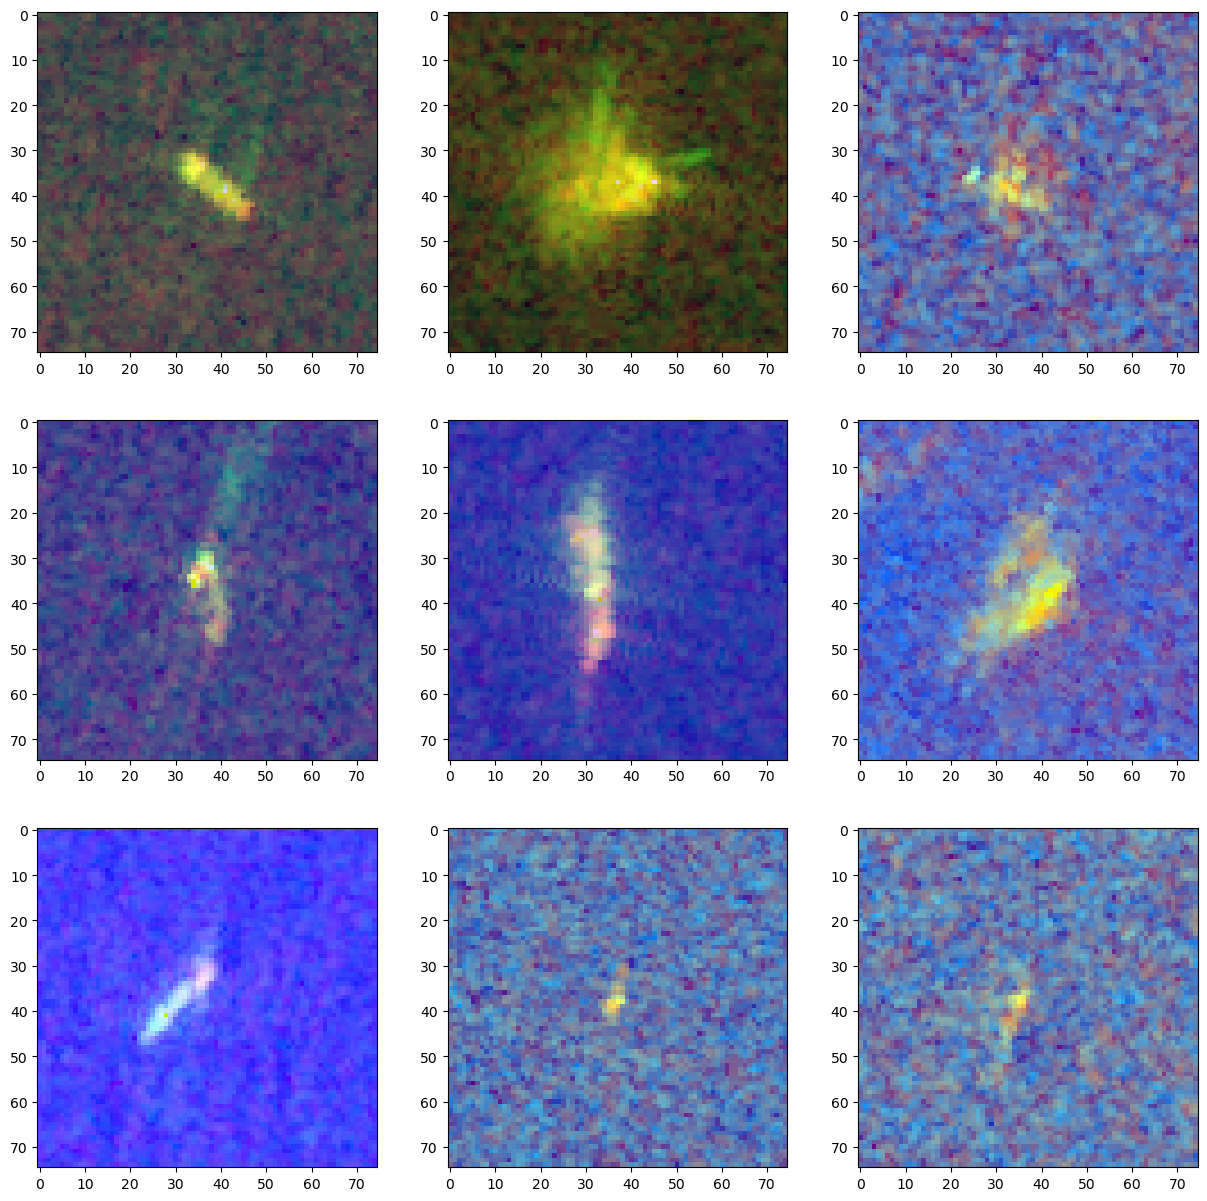

In [7]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

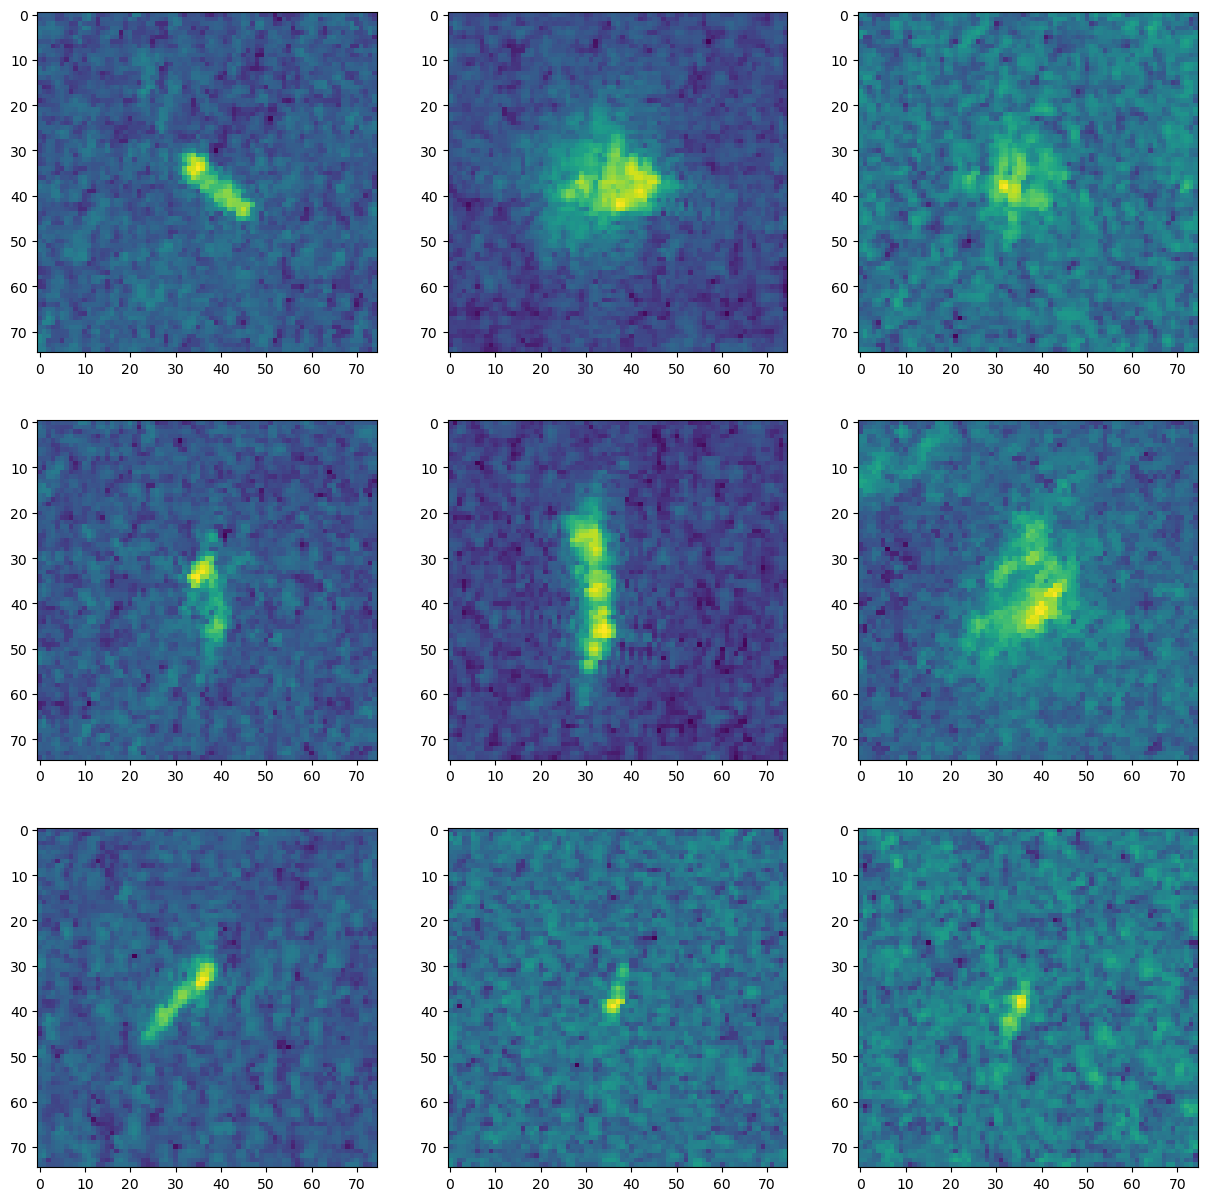

In [8]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

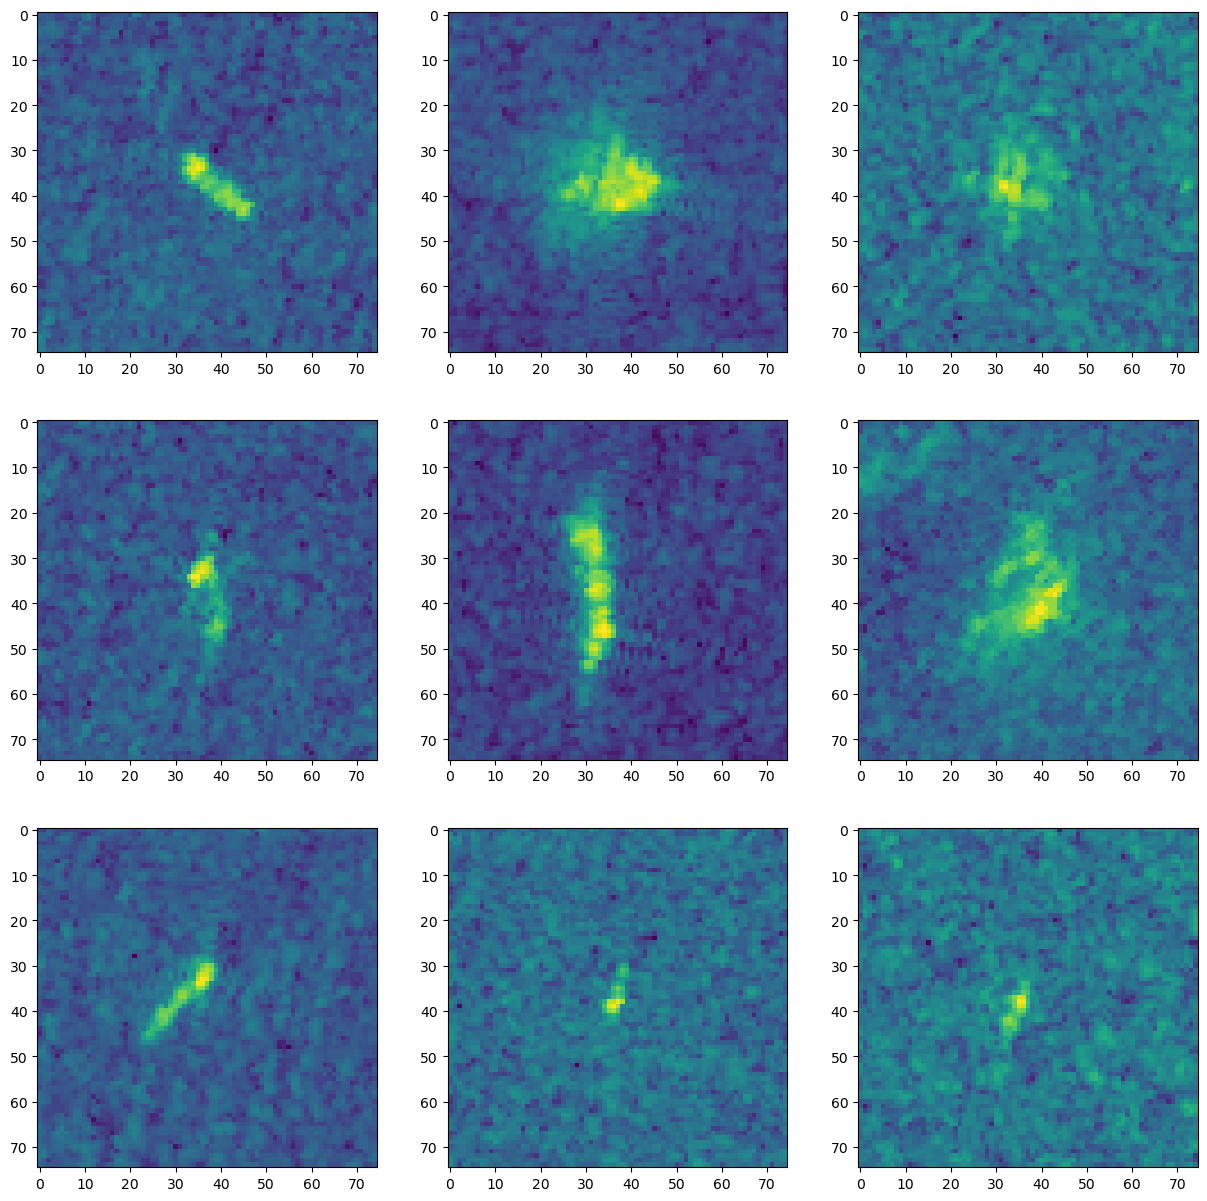

In [9]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

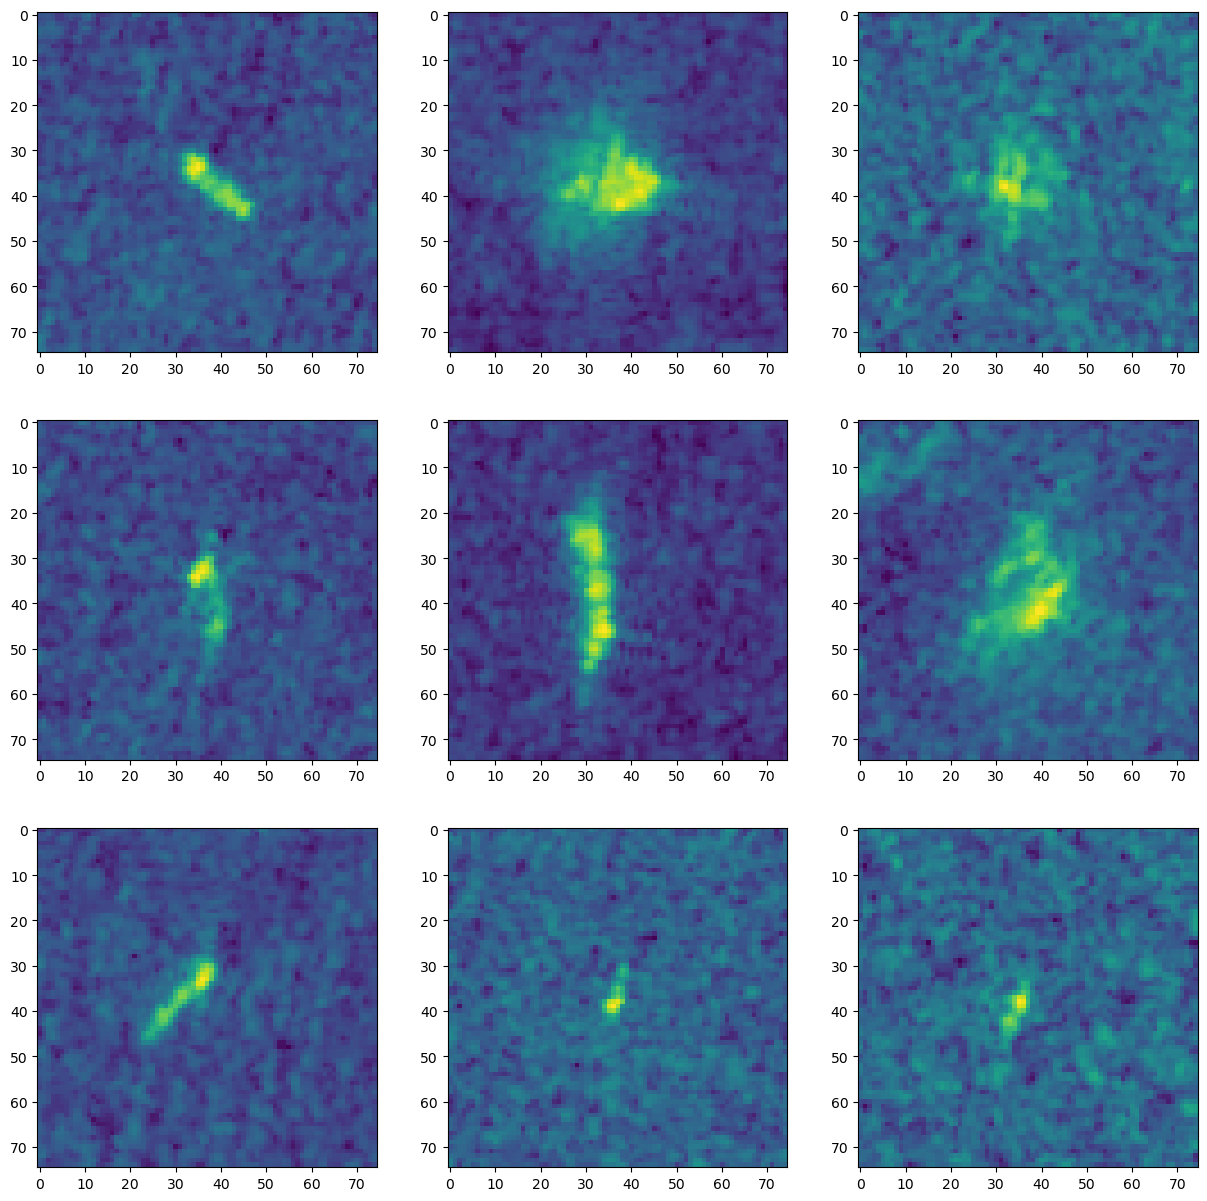

In [10]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

**A few words about model**

The model itself consists of 3 convolutional neural networks. Two basic networks and one combined. The idea is to train two basic networks on different data representations and after that, using trained convolutional layers in combination to train common network.

Architecture for these networks is taken from notebook mentioned in the vere beginning.

For training i'm using 3 datasets, 1 that network sees only once and default keras val split for model selection.

**DeepL 번역**  

모델 자체는 3개의 컨볼루션 신경망으로 구성됩니다. 두 개의 기본 네트워크와 하나의 결합 네트워크. 서로 다른 데이터 표현에 대해 두 개의 기본 네트워크를 훈련한 다음, 훈련된 컨볼루션 레이어를 조합하여 공통 네트워크를 훈련하는 것이 아이디어입니다.

이러한 네트워크의 아키텍처는 앞부분에서 언급한 노트북에서 가져왔습니다.

훈련에는 3개의 데이터 세트, 네트워크가 한 번만 보는 데이터 세트, 모델 선택을 위한 기본 케라스 값 분할을 사용하고 있습니다.

In [11]:
def get_model_notebook(lr, decay, channels, relu_type='reklu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 785, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activatio=relu_type)(BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activatio=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activatio=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activatio=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason I've decided not to normaliuze angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    # optimizer = Adam(lr=lr, decay=decay)    # 인자명 변경됨.
    optimizer = Adam(learning_rate=lr, decay=decay)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model, partial_model

In [12]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    # for layer in m_b.layers:
    #     layer.trainable = False
    # for layer in m_img.layers:
    #     layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation='sigmoid')(common)
    model = Model([input_b, input_img], output)
    # optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)   # 인자명 변경
    optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

https://www.kaggle.com/code/wvadim/keras-tf-lb-0-18